In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import os
import matplotlib.pyplot as plt

In [2]:
def calculate_feature_importance(input_dir, n_folds=5):
    all_y_true = []
    all_y_pred = []
    feature_importance_df = pd.DataFrame()

    # K-Fold Cross Validation
    for fold in range(1, n_folds + 1):
        #load training and test sets for this fold
        train = pd.read_csv(os.path.join(input_dir, f'training_data_fold{fold}.csv'), index_col=0)
        test = pd.read_csv(os.path.join(input_dir, f'test_data_fold{fold}.csv'), index_col=0)

        #extract numeric features 
        numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
        features = [col for col in numeric_features if col != 'TSI_days']

        #log transformation
        y_train = np.log1p(train['TSI_days'] / 365)
        y_test = np.log1p(test['TSI_days'] / 365)
        X_train = train[features]
        X_test = test[features]

        #train model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        #predict
        y_pred = model.predict(X_test)
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        # Store feature importance for current fold
        fold_feature_importance = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_,
            'Fold': fold
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_feature_importance], axis=0)

    return feature_importance_df

## A - P-spline dataset

In [ ]:
input_dir = './data/derived/smoothed/pspline/'
feature_importance_df = calculate_feature_importance(input_dir)
feature_importance_df.to_csv('feature_importance_all_features.csv', index=False) #save feature importance scores

In [6]:
#average importance scores 
average_importance = feature_importance_df.groupby('Feature')['Importance'].mean().sort_values(ascending=True)

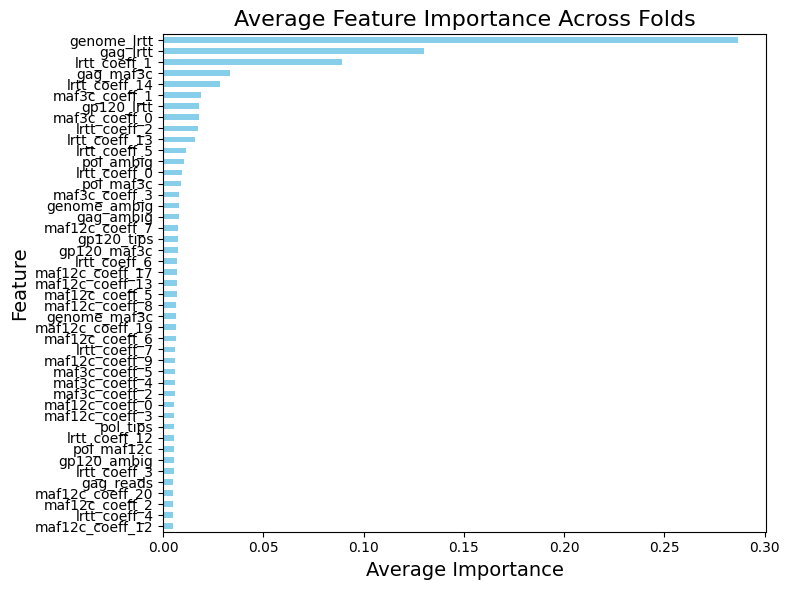

In [7]:
average_importance_sorted = average_importance.sort_values()
importance_threshold = 0.005
important_features = average_importance[average_importance > importance_threshold].sort_values()

plt.figure(figsize=(8, 6))
important_features.plot(kind='barh', color='skyblue')

plt.title('Average Feature Importance Across Folds', fontsize=16)
plt.xlabel('Average Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()